# Nested samping using Galilean Monte Carlo

This example demonstrates how to use Galilean Monte Carlo sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data. For a tutorial on nested sampling, see: [INSERT LINK to NESTED SAMPLING TUTORIAL NOTEBOOK].

[1] "Exploring Multi-Modal Distributions with Nested Sampling", 2013, Farhan Feroz and John Skilling.

First create fake data.

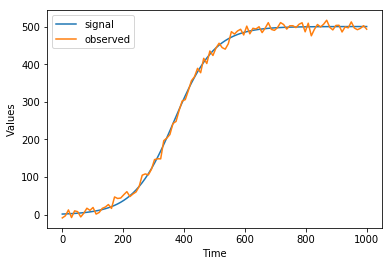

In [1]:
import os
os.chdir('C:/Users/bclamber/Desktop/AllPints/pints4/pints')
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
r = 0.015
k = 500
real_parameters = [r, k]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
sigma = 10
observed_values = signal_values + pints.noise.independent(sigma, signal_values.shape)

# Plot
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

Create the nested sampler that will be used to sample from the posterior.

In [5]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, sigma * 0.5],
    [0.02, 600, sigma * 1.5])

# Create a nested ellipsoidal rejectection sampler
sampler = pints.NestedEllipsoidSampler(log_likelihood, log_prior)

# Set number of iterations
sampler.set_iterations(4000)

# Set enlargement factor (a value of 1 means uniformly sample from the minimum volume 
# ellipsoid around sampled points, whereas > 1 widens the sampling volume)
sampler.set_enlargement_factor(1.25)

# Set number of initial rejection samples (before ellipsoidal sampling begins)
sampler.set_rejection_samples(200)

# Set the number of posterior samples to generate
sampler.set_posterior_samples(400)

# Set gaps between updating ellipsoid
sampler.set_ellipsoid_update_gap(100)

# Set the number of active points
sampler.set_active_points_rate(400)

sampler.set_log_to_screen(False)

Run the sampler!

In [8]:
samples, marginal_log_likelihood = sampler.run()
print('Done!')

Done!


## Plot posterior samples versus true parameter values (dashed lines)

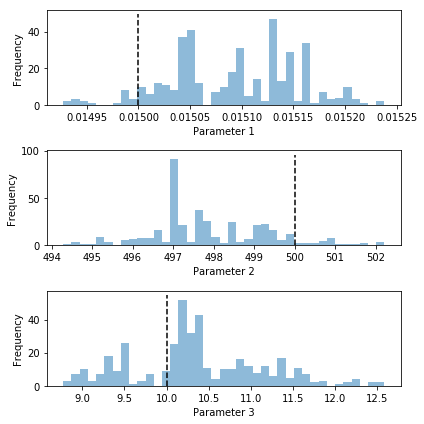

In [9]:
# Plot output
import pints.plot

pints.plot.histogram([samples], ref_parameters=[r, k, sigma])

plt.show()

/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


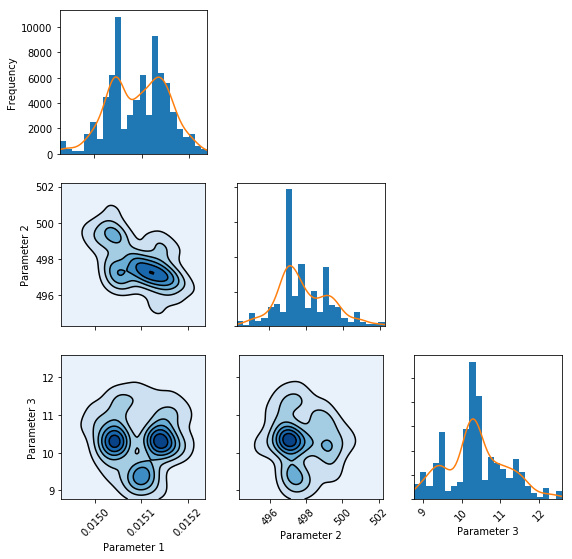

In [10]:
vTheta = samples[0]
pints.plot.pairwise(samples, kde=True)

plt.show()

## Plot posterior predictive simulations versus the observed data

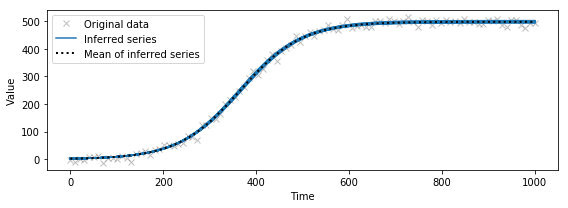

In [11]:
pints.plot.series(samples[:100], problem)
plt.show()

## Marginal likelihood estimate

In [12]:
print('marginal log-likelihood = ' + str(marginal_log_likelihood))

marginal log-likelihood = -386.2218757369907


In [19]:
x = [0.015, 500, 10]
epsilon = 10**(-10)
v_gradient = np.zeros(len(x))
for i in range(len(x)):
    x_temp_upper = np.copy(x)
    x_temp_upper[i] += epsilon
    x_temp_lower = np.copy(x)
    x_temp_lower[i] -= epsilon
    v_gradient[i] = (log_likelihood(x_temp_upper) - log_likelihood(x_temp_lower)) / (2 * epsilon)
v_gradient

array([ -1.27830731e+04,  -6.65068001e-02,  -6.60520527e-01])

In [12]:
log_likelihood(x)

-368.85173762671536